# Определение эмоциональной окраски твитов с помощью BERT

При отсутствии более чем одной GPU, даже файнтюнинг BERT может занять существенное количество времени. Поэтому мы рассмотрим, наверное, самую простую задачу, на решение которой будем файнтюнить BERT: будем классифицировать предложения. 
- будем определять эмоциональную окраску твитов с помощью BERT
  - возьмём предобученный BERT 
  - добавим к нему слой нейронов, чтобы обучить полученную модель для классификации предложений
- не будем кодить руками обучение BERT, а покажем, как, максимально просто, максимально быстро, найти готовый предобученный BERT и, минимальным количеством кода, дофайнтюнить его для решения вашей задачи

Авторы статьи про BERT советуют запускать всего от двух до четырёх эпох, чтобы получить хороший результат

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

## Установка библиотек

`pytorch-transformers`:
- есть pytorch-интерфейс BERT, 
- есть удобные обёртки и для других популярных моделей (например, для XL трансформера, или GPT-2, или каких-то других моделей — например, для RoBERTa[1])
- есть специальные модификации для конкретных задач. Например, для задачи классификации предложений (классификации текстов)
 
На сегодняшний день, пожалуй, эта библиотека является самой популярной обёрткой для удобного использования BERT. 

[1] Liu Y. et al. Roberta: A robustly optimized bert pretraining approach //arXiv preprint arXiv:1907.11692. – 2019.

In [2]:
# !pip install pytorch-transformers
# !pip install tensorflow
# !pip install keras
# !pip install transformers sentencepiece

tensorflow под CUDA 11, под 10.2 вобще нету (собирать из исходников), только 10.1, т.е. на моем GPU не пойдет
- ставим скачанный под CPU pip install /mnt/EXT_STORAGE/Soft/CUDA/wheels/tensorflow_cpu-2.8.0-cp39-cp39-manylinux2010_x86_64.whl

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences  # require tensorflow
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# сама модель BERT это 9.2 Гб тензоров, поэтому не на всяком GPU пойдет
# device = 'cpu'
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

NVIDIA GeForce GTX 760


### Еще полезные штуки

- Таблица параметров модели. Типа подробный `get_parameters()` 
- Все тензоры ноутбука
- Очистить память от ненужных тензоров/моделей

In [1]:
from helpers.summary import count_parameters, dump_tensors, free_mem

## Загрузка данных


Мы выбрали необычный датасет с разметкой сентимента русскоязычных твитов (подробнее про него в [статье](http://www.swsys.ru/index.php?page=article&id=3962&lang=)). В корпусе, который мы использовали 114,911 положительных и 111,923 отрицательных записей. Загрузить его можно [тут](https://study.mokoron.com/).

Датасет нам известен, уже посмотрели, на сегодня он не аллё по большому счету (на момент составления мож ищо туда-сюда):
- охватывает короткий период зимы 2013-2014 года
- авторазметка на основе смайликов неадекватна чуть более чем полностью (субъективно выборочно, тут могут быть другие мнения)
  - как в топ позитивных биграм попадает `идиот целый`, например? Короче специфика лексики + специфика периода
  - в чем была проблема хотя бы хеш-теги и урлы в отдельное поле вынести? Можно было б признак собрать +/- рабочий...
- ценность тут не в разметке, а в том, что на ее основе была проанализирована морфологическая разметка (сочетания частей речи, характерные для положительных/отрицательных сообщений, и вот на ней уже можно что-то стоящее собрать, но исходные данные для этого хреновые, так что вот)

**Очень любопытно, что жы покажет BERT**

[1] Корпус коротких текстов Юлии Рубцовой: http://study.mokoron.com/  

In [5]:
import pandas as pd

# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
pos_texts = pd.read_csv('datasets/bert_sentiment_analysis/positive.csv', encoding='utf8', sep=';', header=None)
neg_texts = pd.read_csv('datasets/bert_sentiment_analysis/negative.csv', encoding='utf8', sep=';', header=None)

In [6]:
pos_texts.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11
62503,410304406702538752,1386659168,LediDu,"@VadimKovalev я тоже в свое время по ""любви"" в...",1,0,0,0,11794,810,357,9
18129,409377737779191809,1386438233,Ard_Rhena,"@jester_zaffiro как быстро ты сдался, хехе..)\...",1,0,0,0,5440,93,52,1
17241,409368929006813184,1386436133,nikadavdav,@DakotaMossIA @KatrynSLF @Marianna_Bis чья бы ...,1,0,0,0,6195,48,42,0
112353,411208490527768576,1386874718,sashulkaar,"RT @AnyaSweet2603: аааа, прослезилась даже))))...",1,0,2,0,4120,39,54,0
71300,410475422477197312,1386699941,Nesti_N,"@MsKarlson ахах не не бойся) я аккуратно, я ж ...",1,0,0,0,7140,227,133,1


In [7]:
pos_texts[3].apply(lambda x: len(x)).mean()

85.200590021843

Добавим токен начала текста `[CLS]` и разделитель `[SEP]`

In [8]:
sentences = np.concatenate([pos_texts[3].values, neg_texts[3].values])

sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = [[1] for _ in range(pos_texts.shape[0])] + [[0] for _ in range(neg_texts.shape[0])]

In [9]:
assert len(sentences) == len(labels) == pos_texts.shape[0] + neg_texts.shape[0]

In [10]:
print(sentences[1000])

[CLS] Дим, ты помогаешь мне, я тебе, все взаимно, все правильно) [SEP]


Тренировочная и тестовая выборки

In [11]:
from sklearn.model_selection import train_test_split

train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.3)

In [12]:
print(len(train_gt), len(test_gt))

158783 68051


## Inputs

Импортируем токенизатор для BERT (`pytorch_transformers.BertTokenizer`), который превратит наши тексты в набор токенов, соответствующих тем, что встречались в словаре предобученной модели:

`bert_base_uncased` это модель, которая меньше, чем BERT Large, и содержит внутри 12 self-attention модулей
- "Uncased" означает, что все слова в словаре этого токенайзера написаны в нижнем регистре

*Заняло около минуты*

In [13]:
from pytorch_transformers import BertTokenizer, BertConfig


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print (tokenized_texts[0])

['[CLS]', 'ч', '##т', '##о', 'о', '##д', '##на', 'и', 'т', '##а', 'ж', '##е', 'к', '##о', '##с', '##м', '##е', '##т', '##и', '##ка', 'у', 'н', '##а', '##с', 'с', 'р', '##ы', '##ж', '##е', '##и', '.', 'м', '##ы', ',', 'н', '##а', '##в', '##е', '##р', '##н', '##о', '##е', ',', 'у', '##ж', 'о', '##ч', '##е', '##н', '##ь', 'д', '##о', '##л', '##г', '##о', 'з', '##на', '##к', '##о', '##м', '##ы', ')', ')', ')', '[SEP]']


Решетками обозначены так сказать "суффиксы" и "окончания", т.е. часто встречающиеся дополнения к другим токенам. Тут у BERT свой алгоритм токенизации (wordpieces). В данном случае он выдает почти посимвольное кодирование.

In [14]:
train_sentences[0]

'[CLS] Что одна и та же косметика у нас с Рыжей. Мы ,наверное, уж очень долго знакомы))) [SEP]'

BERTу (в исполнении `pytorch_transformers`) нужно предоставить специальный формат входных данных.

- **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
- **labels**: вектор из нулей и единиц. В нашем случае нули обозначают негативную эмоциональную окраску, единицы - положительную.
- **segment mask**: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух: <length_of_sent_1> нулей и <length_of_sent_2> единиц. **Зачем это нужно?**
  - BERT предобучается на двух задачах (предсказание маскированных слов в тексте, определение, является ли одно предложение продолжением другого предложения). Т.е. так в BERT подается информация о том, есть ли у нас два предложения в нашем входе, либо оно одно, нам нужен этот параметр segment_mask (почему он сам по `[SEP]` не поймет?).
- **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.

Паддинг нужен для того, чтобы BERT мог работать с предложениями разной длины. Ну, например, в нашем случае, мы можем сказать, что максимальная длина предложения у нас будет равна 100, можно выбрать какую-то другую длину, это не сильно важно. И теперь более длинные предложения мы будем обрезать до 100 токенов, а для более коротких предложений использовать паддинг.
- зачем тогда `[SEP]`?

Чтобы добавить паддинг нашим предложениям, мы будем использовать готовую функцию из `keras` под названием `pad_sequences` (вот без керас/тензорфлоу паддинг не сделать никак...)
- средняя длина сообщений 85 символов

In [15]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

Из тренировочной выборки выделяем **валидационную**:
- на тренирочной выборке вычисляются **параметры** модели (веса, градиенты и т.п.)
- на валидационной выборке подбираются **гиперпараметры** модели (количество слоев, дропауты и т.п.) - тут нам это не понадобится
- на тестовой (если сценарий обучения включает валидационную выборку) оценивается уже тольк финальная модель

In [16]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

**Данные - в тензоры**

In [17]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [18]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

Метки классов это **столбец** - тут не принципиально, а вообще так делается, если объекту нужно несколько меток классов присваивать (типа тегов, например)

In [19]:
train_labels

tensor([[1],
        [0],
        [1],
        ...,
        [1],
        [1],
        [0]])

Создаем итераторы по данным с помощью `DataLoader` из торча, чтоб не грузить все данные в память.

К тренировочному датасету прикручивается `RandomSampler` к валидационному достаточно подавать по очереди (`SequentialSampler`).

Тут же задается объем батча (обучающего пакета)

In [20]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)

train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=32
)

In [21]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)

validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=32
)

## Обучение модели

Загружаем [BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129):
- это готовая модификация BERT для классификации
- т.е. это обычный BERT с добавленным одним линейным слоем для классификации

In [23]:
from pytorch_transformers import AdamW, BertForSequenceClassification

Как мы помним, первый токен в каждом предложении в наших данных — это метка `[CLS]`. Скрытое состояние, относящееся к этой метке, должно содержать в себе агрегированное представление всего предложения (ибо она есть у всех предложений корпуса), которое дальше будет использоваться для классификации. 

Таким образом, когда мы скормили предложение в процессе обучения сети, выходом должен быть вектор со скрытым состоянием, относящийся к метке `[CLS]`. 

Дополнительный полносвязный слой, который мы добавили (руками `BertForSequenceClassification`), имеет размерность ["hidden state", "количество классов"] — это 2д тензор. И в нашем случае, количество классов равно "2", то есть, на выходе мы получим два числа, представляющих классы "положительная эмоциональная окраска", "отрицательная эмоциональная окраска". 

Сам процесс дообучения вычислительно достаточно дешёв. По факту, мы тренируем наш верхний слой и немного меняем веса во всех остальных слоях. Иногда некоторые слои специально замораживают или применяют разные стратегии работы с learning rate. В общем делают всё, чтобы сохранить хорошие веса в нижних слоях и ускорить процесс дообучения. 

В целом, замораживание слоёв BERT обычно не сильно сказывается на итоговом качестве, однако стоит помнить о тех случаях, когда домен для предобучения и дообучения был разным. Например, когда мы предобучили нашу сеть на каких-то официальных текстах (на правовых актах или на научных статьях), а дообучаем её на, например, твитах, на неформальной лексике. В таких случаях лучше тренировать все слои сети, не замораживая ничего.

И кстаи, аналогичные модели есть и для других задач

In [24]:
from pytorch_transformers import BertForQuestionAnswering, BertForTokenClassification

Создаем модель:
- `pytorch_transformers` бодро (за 1 мин.) выкачивает где-то 440 Мб упакованных параметров $BERT_{base}$
- Созданный объект модели номинально занимает примерно **9.2 Гб** (включая наш последний слой на 2 X 768 = 1536 (+2 смещения) параметров)
- Конечно, такая махина не в каждый GPU влезет, чтоб его целиком переобучать
  - а по частям не получится, данные и модель должны быть на одном устройстве... как это имелось в виду запускать? 
  - имелся в виду гуглоколаб с Tesla P100 16 Gb

Не лезет в GPU, штош:
- зачем на 768 размер входа для твиторов по 80 символов (токенов и того меньше), но
  - уменьшить размеры входов, эмбеддингов, число скрытых состояний энкодеров, словарь не получится, модель сохранена именно в таком виде, и не загрузится в другой конфигурации
- зато можно уменьшить число самих энкодеров и голов механизма внимания
  - в 760gtx 2 Gb влезло только по минимуму: 2 энкодера по 2 головы в каждом

In [25]:
configuration = BertConfig(num_labels=2,
                            vocab_size=30522,
                            hidden_size=768,    
                            num_hidden_layers=2,#12,
                            num_attention_heads=2,#12,
                            intermediate_size=3072,)

In [26]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=configuration)
model.to(device)

count_parameters(model)

+--------------------------------------------------------+-----+-------------+------------+---------------+------------+
|                    Modules/Tensors                     | GPU |    Shape    | Parameters |      Type     |   Memory   |
+--------------------------------------------------------+-----+-------------+------------+---------------+------------+
|         bert.embeddings.word_embeddings.weight         |  +  | 30522 x 768 |  23440896  | torch.float32 | 2062798848 |
|       bert.embeddings.position_embeddings.weight       |  +  |  512 x 768  |   393216   | torch.float32 |  34603008  |
|      bert.embeddings.token_type_embeddings.weight      |  +  |   2 x 768   |    1536    | torch.float32 |   135168   |
|            bert.embeddings.LayerNorm.weight            |  +  |     768     |    768     | torch.float32 |   67584    |
|             bert.embeddings.LayerNorm.bias             |  +  |     768     |    768     | torch.float32 |   67584    |
|    bert.encoder.layer.0.attent

38605058

Авторы статьи про BERT советуют выбирать: 
- learning rate из следующего списка: $5 \cdot 10^{-5}, 3 \cdot 10^{-5}, 2 \cdot 10^{-5}$, 
- количество эпох дообучения: 2, 3, 4.
- размер батча: 16, 32

### Создаем параметры обучения 
В виде json подобной структуры, где:
- `no_decay` паттерны имен параметров, по которым не пересчитывать градиенты

### Оптимизатор с "регуляризацией"

`AdamW` - это реализация `Adam` с применением **Weight Decay**. 

Что такое Weight Decay? При каждом обновлении веса давайте кроме движения в сторону антиградиента еще и будем вычитать маленький кусочек веса, умноженный на некоторый гиперпараметр. Например, формула стохастического градиентного спуска с применением Weight Decay будет выглядеть так:

$w = w - lr * \dfrac{\partial L}{\partial w} - lr * wd * w$ 

Здесь lr - learning rate, wd - weight decay, гиперпараметр.

Если Вы внимательно посмотрите на эту формулу, то заметите, что в случае стохастического градиентного спуска Weight Decay эквивалентен применению L2-регуляризации к loss-функции:

$$L_{new} = L + \dfrac{wd}{2} ||w||^2 \\
 
\dfrac{\partial (L_{new})}{\partial w} = \dfrac{\partial L}{\partial w} + wd \cdot w \\

w = w - lr \cdot \dfrac{\partial L_{new}}{\partial w} = w - lr * \dfrac{\partial L}{\partial w} - lr * wd * w $$

Однако, L2-регуляризация (**меняем loss-функцию**) и Weight Decay (**не меняем loss-функцию**, меняем только способ обновления весов) работают одинаково только в простом случае стохастического градиентного спуска, в случае адаптивных оптимизаторов, например, Адама, эти два подхода различаются (причем эмпирически было показано, что часто Weight Decay работает лучше). Вся эта история породила некоторую путаницу в терминилогии, и во многих библиотеках Адам реализовали именно с применением L2-регуляризации, ошибочно называя такой подход Weight Decay.  Авторы статьи [Decoupled Weight Decay Regularization](https://arxiv.org/abs/1711.05101) решили разграничить Adam+L2 и Adam+Weight Decay, назвав последнее AdamW.

In [27]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

### Цикл обучения

На самом деле это 1 итерация цикла (1 эпоха), если надо, можно еще раз тыкнуть ичейку.

- переводим модель в train mode, 
- распаковываем входные данные (вектор с индексами токенов и метки классов)
- помещаем наши данные на GPU с помощью 
- не забываем очистить градиенты с прошлого шага с помощью `zero_grad()` 
- делаем forward pass, считаем loss, затем делаем backward pass, считаем градиенты, 
- дальше — стандартно — делаем optimizer.step(). 
 
Кроме того, в процессе обучения мы будем рисовать график и считать лосс. В конце каждой эпохи (в нашем случае — в конце единственной эпохи) посчитаем лосс на нашей обучающей выборке.

- На GPU у авторов семинара: ~15 мин./ эпоха
- На GPU на старой видеокарте: ~40 мин./ эпоха (на урезанной с 12х12 до 2 энкодеров по 2 головы модели)

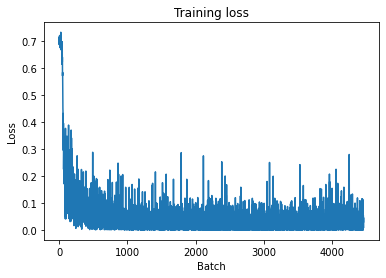

Loss на обучающей выборке: 0.05143
Процент правильных предсказаний на валидационной выборке: 97.73%


In [28]:
from IPython.display import clear_output

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()


for step, batch in enumerate(train_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Backward pass
    loss[0].backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))


# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

In [29]:
print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на валидационной выборке: 97.73%


# Оценка качества на отложенной выборке

In [30]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)

In [31]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=32
)

- На GPU на старой видеокарте: ~5 мин. (на урезанной с 12х12 до 2 энкодеров по 2 головы модели)

In [32]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

In [33]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 97.67%


In [34]:
print('Неправильных предсказаний: {0}/{1}'.format(
    sum([z[0] != z[1] for z in zip(test_labels,  test_preds)]),
    len(test_labels)
))

Неправильных предсказаний: 1586/68051


Мы показали, что предобученный BERT может быстро (всего за одну эпоху) давать хорошее качество при решении задачи анализа эмоциональной окраски текстов. Кроме того, обратите внимание, что мы не тюнили параметры и использовали сравнительно маленький размеченный корпус, чтобы получить accuracy больше 98%. Тем не менее, если не делать дообучение под конкретную задачу вовсе, то получить хорошее качество вряд ли выйдет.

- как языковая модель BERT очень хорош, т.е.
  - сама классификая - по языковой модели выбор меток как в обучающей выборке - решается на ура
  - это не отменяет того, что сама обучающая выборка слабая
- для такой задачи совершенно не нужны все 12 слоев модели BERT

### Домашнее задание

Скачайте датасет с отзывами на фильмы. Например, используйте датасет [IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). 

In [2]:
import pandas as pd

# dataset = pd.read_csv('./datasets/bert_sentiment_analysis/homework/IMDB_Dataset.csv')
# dataset.head()

Используйте для дообучения BERT датасет IMDB. 

Ответьте на вопросы:
1. удалось ли достичь такого же accuracy (98\%) при использовании IMDB датасета?
2. удалось ли получить хорошее качество классификации всего за одну эпоху?
3. подумайте, в чем может быть причина различий в дообучении одной и той же модели на разных датасетах
    - Внимательно изучите датасет с русскими твитами. В чем его особенности? Нет ли явных паттернов или ключевых слов, которые однозначно определяют сентимент твита?
    - Попробуйте удалить пунктуацию из датасета с русскими твитами и перезапустите дообучение модели. Изменилось ли итоговое качество работы модели? Почему?

**на BERT мы этого делать не будем**

# Заморозка слоев модели

Иногда используется в сценариях трансферлернинга, дообучения и т.п., чтобы не тратить время на пересчет backbone модели.

В общем в PyTorch есть несколько способов заморозить слои (по сути, защитить их от изменения оптимизатором).

Допустим у нас есть следующая модель:

    class OurModel(nn.Module):
        def __init__(self):
            super().__init__()
            self.pretrained_model = load_super_pretrained_model()
            self.output_layer = nn.Linear(...)
 

**Способ 1 (предпочтительный).** Не передавать в оптимизатор те параметры, которые надо заморозить

Обычно мы создаём оптимизатор для такой модели как

    model = OurModel()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Если мы не хотим учить часть нашей модели (например, предобученные слои self.pretrained_model), тогда можно сделать так:

    model = OurModel()
    optimizer = torch.optim.Adam(model.output_layer.parameters(), lr=1e-3)

Это подход "по умолчанию".

**Способ 2.** Грязный хак: спрятать параметры от самой модели

Когда мы вызываем model.parameters(), модель делает проход по своим полям и либо собирает экземпляры класса nn.Parameter, либо рекурсивно вызывает .parameters()  (если поле имеет тип nn.Module). Если модель видит поле какого-то другого типа, она его игнорирует.

Поэтому можно обернуть вложенную модель, которую не надо учить, например, в список.

    class OurModel(nn.Module):
        def __init__(self):
            super().__init__()
            self.pretrained_model = [load_super_pretrained_model()]
            self.output_layer = nn.Linear(...)

В этом случае в оптимизатор не попадут параметры self.pretrained_model

    model = OurModel()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Этим можно пользоваться осторожно, но надо помнить, что в разработке явное лучше, чем скрытое.

**Способ 3.** Гибкий вариант: занулять градиенты параметров руками

После того, как мы вызвали loss.backward(), у всех объектов-экземпляров класса nn.Parameter появится атрибут .grad, это тензор, имеющий ту же форму, что и сам тензор параметров, и содержащий значения производной функции потерь по этой переменной.

Тогда можно руками пройтись по нужным параметрам и занулить у них grad. При этом надо именно обнулить значения тензора, а не перезаписать его нулём (обратите внимание на квадратные скобки):

    loss.backward()
    for param in model.pretrained_model.parameters():
        param.grad[:] = 0  # или param.grad.zero_()
        
Такой вариант наиболее удобен, когда надо на разных шагах оптимизации нужно оптимизировать разные переменные. Это достаточно экзотическая ситуация и в рамках этого курса это не пригодится, лучше пользоваться первым способом.